[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tannhorn/some-notebooks/blob/main/secretary_problem/part_2.ipynb) [![GitHub](https://img.shields.io/badge/GitHub-black?logo=github)](https://github.com/tannhorn/some-notebooks/blob/main/secretary_problem/part_2.ipynb)

*This notebook is a follow-up to the [first part](https://colab.research.google.com/github/tannhorn/some-notebooks/blob/main/secretary_problem/part_1.ipynb) so make sure to start there.*

## Recap

In the first part, we looked at the classic [Secretary Problem](https://en.wikipedia.org/wiki/Secretary_problem), what is its theoretical solution and how we can recover that numerically. We also extended the problem by adding uncertainty to our ability to rank candidates. In this part, we will look at further extensions, considering:

- What if the number of candidates is uncertain?
- What if we are not looking for the best candidate but anyone in the top x-% of the pool will do?

And, as a bonus, we will simulate a two-round interview system. So let's get to it!

## Uncertain number of candidates

In all our previous work, we have assumed that $n$, the number of candidates to be interviewed, is known precisely and in advance by the interviewer. Now we will instead assume an uncertainty. We will take the code we have used last time and modify it slightly to allow for this. We will also re-use some more code.

In [20]:
import numpy as np
from matplotlib import pyplot as plt
import json
import requests

In [5]:
# Define the function for which you want to find the maximum
def classic_dist(r, n):
    if r == 1:
        return 0
    else:
        return (r - 1) / n * np.sum([1 / (i - 1) for i in range(r, n+1)])

# Define a function to solve the problem for a specific n
def classic_solve(n):
    if n == 1:
        return 0, 1
    else:
        values = np.array([classic_dist(r, n) for r in range(1, n+1)])
        r_max = np.argmax(values) + 1
    return r_max - 1, values[r_max - 1] # we return r_max - 1 since we want to know the number of excluded candidates

classic_solve_vect = np.vectorize(classic_solve, otypes=[int, float])

In [7]:
ns = np.arange(4,101, step=4)

classic_stops, classic_probs = classic_solve_vect(ns)
classic_probs *= 100

In [6]:
def solve_and_print(func, start_text, n, *args):
    sol = func(n, *args)
    print(start_text + f" for {n} candidates: Reject until and including candidate no. {sol[0]} and the probability is {(sol[1]*100):.1f}%.")

In [9]:
def random_ordering(n):
    return np.random.rand(n)

In [18]:
def uncertain_numeric_solve_1(n, uncertainty_eval):
    ordering = random_ordering(n)
    # best overall is selected with the exact ordering
    best_overall = np.max(ordering)
    # now we switch to a fuzzy ordering
    fuzzy_ordering = ordering + uncertainty_eval * random_ordering(n)
    
    evals = np.zeros(n, dtype=bool)
    best_rejected = 0

    for r in range(n):
        if r > 0 and fuzzy_ordering[r-1] > best_rejected:
            best_rejected = fuzzy_ordering[r-1]
        remain = fuzzy_ordering[r:]
        higher_indices = remain > best_rejected
        # we need to modify the actual comparison
        if np.any(higher_indices):
            select_idx = r + np.argmax(higher_indices)
            evals[r] = (ordering[select_idx] == best_overall)
        else:
            evals[r] = False
    return evals

def uncertain_numeric_solve(n, sampling, uncertainty_eval, uncertainty_n):
    # we first generate an upper bound on 'n', since we are using uniform probability distributions
    # we round up to nearest integer
    # we divide by 2 since we consider the uncertainty to be a band
    delta_n = np.ceil(uncertainty_n/2 * n).astype(int)
    n_max = n + delta_n
    evals = np.zeros(n_max, dtype=float)
    for _ in range(sampling):
        sample_n = n + np.random.randint(-delta_n, delta_n + 1)
        sample_eval = uncertain_numeric_solve_1(sample_n, uncertainty_eval)

        if n_max > sample_n:
            padded_sample_eval = np.pad(sample_eval, (0, n_max - sample_n), 'constant', constant_values=False)
        else:
            padded_sample_eval = sample_eval

        evals += padded_sample_eval

    evals /= sampling

    max_idx = np.argmax(evals)
    return max_idx, evals[max_idx]

The above is the modified code from part one. As you can see, it has not taken much to make it work with uncertain $n$. The main addition being the padding of results in case that sample $n$ is less than the maximum possible $n$ to allow for seamless summing of evaluations. Other than that, the code is basically the as before -- and we have even kept the possibility to have non-zero uncertainty of evaluations! Note that I am using uncertainty in the sense of a band of uniform probability, i.e. if the uncertainty in $n$ is 10%, the function will consider the range of sample $n$'s between 95% $n$ and 105% $n$. I think this makes more common sense, the same way diameter is a more practical parameter than radius.

In [28]:
n_test = 50
sampling_size = 100_000
uncertainty_p = 0 # we keep this as zero for simplicity

solve_and_print(classic_solve, "Theoretical solution", n_test)
uncertainty_n = 20
solve_and_print(uncertain_numeric_solve, f"{uncertainty_n}%-uncertain solution", n_test, sampling_size, uncertainty_p/100, uncertainty_n/100)
uncertainty_n = 40
solve_and_print(uncertain_numeric_solve, f"{uncertainty_n}%-uncertain solution", n_test, sampling_size, uncertainty_p/100, uncertainty_n/100)
uncertainty_n = 60
solve_and_print(uncertain_numeric_solve, f"{uncertainty_n}%-uncertain solution", n_test, sampling_size, uncertainty_p/100, uncertainty_n/100)

Theoretical solution for 50 candidates: Reject until and including candidate no. 18 and the probability is 37.4%.
20%-uncertain solution for 50 candidates: Reject until and including candidate no. 18 and the probability is 37.0%.
40%-uncertain solution for 50 candidates: Reject until and including candidate no. 17 and the probability is 36.2%.
60%-uncertain solution for 50 candidates: Reject until and including candidate no. 14 and the probability is 34.6%.


In [21]:
n_uncertain_10_stops, n_uncertain_10_probs = np.zeros(ns.shape,dtype=int), np.zeros(ns.shape,dtype=float)
n_uncertain_20_stops, n_uncertain_20_probs = np.zeros(ns.shape,dtype=int), np.zeros(ns.shape,dtype=float)

for i,n in enumerate(ns):
    n_uncertain_10_stops[i], n_uncertain_10_probs[i] = uncertain_numeric_solve(n, sampling_size, 0, 0.1)
    n_uncertain_20_stops[i], n_uncertain_20_probs[i] = uncertain_numeric_solve(n, sampling_size, 0, 0.2)

n_uncertain_10_probs *= 100
n_uncertain_20_probs *= 100

In [22]:
# Convert the arrays to lists\
n_uncertain_10_stops_list = n_uncertain_10_stops.tolist()
n_uncertain_10_probs_list = n_uncertain_10_probs.tolist()
n_uncertain_20_stops_list = n_uncertain_20_stops.tolist()
n_uncertain_20_probs_list = n_uncertain_20_probs.tolist()

# Create a dictionary to hold the arrays
data = {
    "n_uncertain_10_stops": n_uncertain_10_stops_list,
    "n_uncertain_10_probs": n_uncertain_10_probs_list,
    "n_uncertain_20_stops": n_uncertain_20_stops_list,
    "n_uncertain_20_probs": n_uncertain_20_probs_list
}

# Write the data to a JSON file
with open("part_2_results.json", "w") as json_file:
    json.dump(data, json_file)

NameError: name 'n_uncertain_20_stops' is not defined

In [23]:
def load_json_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        try:
            json_data = json.loads(response.text)
            return json_data
        except json.JSONDecodeError as e:
            print("Error decoding JSON:", e)
            return None
    else:
        print("Failed to load JSON from URL:", url)
        return None

url = "https://raw.githubusercontent.com/tannhorn/some-notebooks/main/secretary_problem/part_1_results.json"
data = load_json_from_url(url)
if data:
    print("JSON data loaded successfully.")
else:
    print("Failed to load JSON data from URL")

# Convert the lists back to NumPy arrays
numerical_stops = np.array(data["numerical_stops"])
numerical_probs = np.array(data["numerical_probs"])
e_uncertain_5_stops = np.array(data["uncertain_5_stops"])
e_uncertain_5_probs = np.array(data["uncertain_5_probs"])
e_uncertain_10_stops = np.array(data["uncertain_10_stops"])
e_uncertain_10_probs = np.array(data["uncertain_10_probs"])

JSON data loaded successfully.


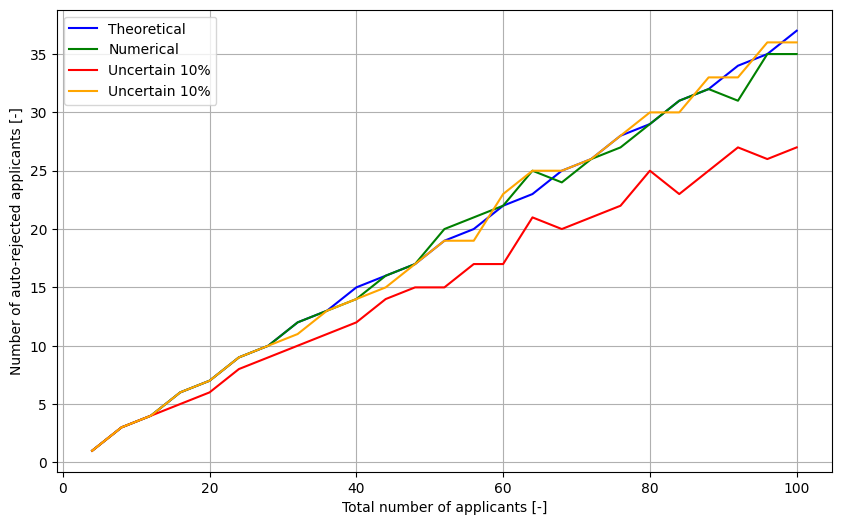

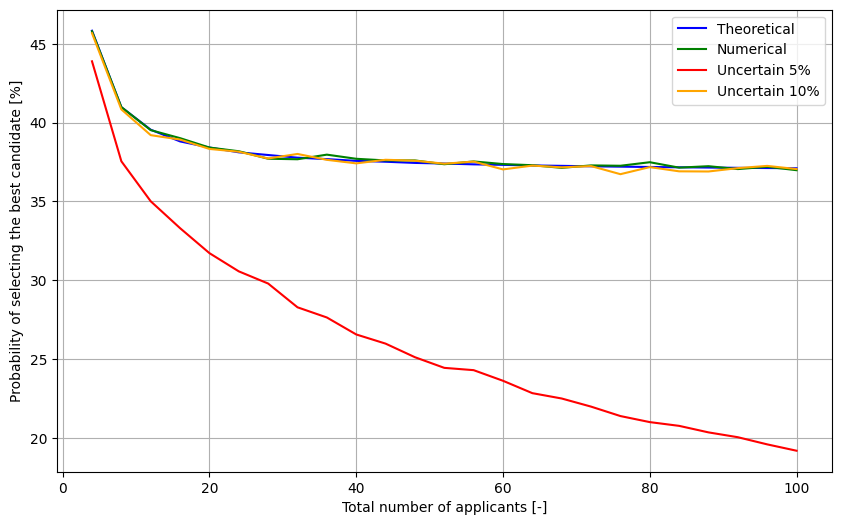

In [24]:
# Plotting stops
plt.figure(figsize=(10, 6))
plt.plot(ns, classic_stops, label='Theoretical', color='blue')
plt.plot(ns, numerical_stops, label='Numerical', color='green')
plt.plot(ns, e_uncertain_10_stops, label='Uncertain 10%', color='red')
plt.plot(ns, n_uncertain_10_stops, label='Uncertain 10%', color='orange')
plt.xlabel('Total number of applicants [-]')
plt.ylabel('Number of auto-rejected applicants [-]')
plt.legend()
plt.grid(True)
plt.show()

# Plotting probs
plt.figure(figsize=(10, 6))
plt.plot(ns, classic_probs, label='Theoretical', color='blue')
plt.plot(ns, numerical_probs, label='Numerical', color='green')
plt.plot(ns, e_uncertain_10_probs, label='Uncertain 5%', color='red')
plt.plot(ns, n_uncertain_10_probs, label='Uncertain 10%', color='orange')
plt.xlabel('Total number of applicants [-]')
plt.ylabel('Probability of selecting the best candidate [%]')
plt.legend()
plt.grid(True)
plt.show()